In [1]:
import numpy as np
# import scipy
# import scipy.stats as sps
# import scipy.fftpack as spfft
# import scipy.signal as spsig
import matplotlib.pyplot as plt
# import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.fft as scft
import sys
import stingray as st
import os

sys.path.insert(1, 'C:/Users/shash/UvA/Thesis/Project/MastersThesis/src/MastersThesis/scripts')

from General import *
from PowerSpec import *
from BiSpectra import *
from SimulatorFuncs import *
from CrossBispec import *
# from Stats_and_Fits import get_chi_sqr

In [2]:
from pypalettes import load_cmap
cmap = load_cmap("Classic_Cyclic")
colors = cmap.colors
len(colors)

13

# Delta function QPOs

## Params

In [86]:
phi1 =       -0.1 * np.pi # Arbitrary phase offset for fundamental in reference band
deltaf_sub = -0.2 * np.pi # Phase difference between the fundamental in the reference band and the fundamental in the subject band
deltah_sub = -0.13 * np.pi # Phase difference between the harmonic in the reference band and the harmonic in the subject band
psi =        -0.05 * np.pi # Phase difference between the fundamental and harmonic in the reference band (defined according to the Ed Nathan paper)

phi1 =       -0.0 * np.pi 
deltaf_sub = -0.0 * np.pi 
deltah_sub = .2 * np.pi 
psi =        .3 * np.pi 

nu_f = 2 # Fundamental freq
nu_h = 2*nu_f # Harmonic freq

dt = 1/64 # Time bin size
ntimes = int(11000 /dt) # Length of light curve 
# ntimes = int(110 /dt) # Length of light curve 
t = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Time bins

A1_ref = 0.1 # Amplitude of sinusoid that defines the fundamental in the reference band
A2_ref = 0.1 # Amplitude of sinusoid that defines the harmonic in the reference band
A1_sub = 0.1 # Amplitude of sinusoid that defines the fundamental in the subject band
A2_sub = 0.1 # Amplitude of sinusoid that defines the harmonic in the subject band

# Define modulation terms in reference band and subject band based on above parameters

phi_f_sub = deltaf_sub
phi_f_sub

A_ref = 1 + A1_ref * np.cos(2*np.pi*nu_f*t - phi1)                + A2_ref * np.cos(2*np.pi*nu_h*t - 2 * (phi1 + psi))

A_sub = 1 + A1_sub * np.cos(2*np.pi*nu_f*t - (phi1 + deltaf_sub)) + A2_sub * np.cos(2*np.pi*nu_h*t - (2 * (phi1 + psi) + deltah_sub))

## Generate broadband noise, modulate it

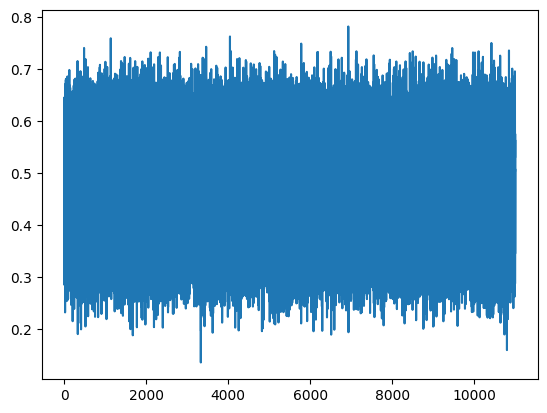

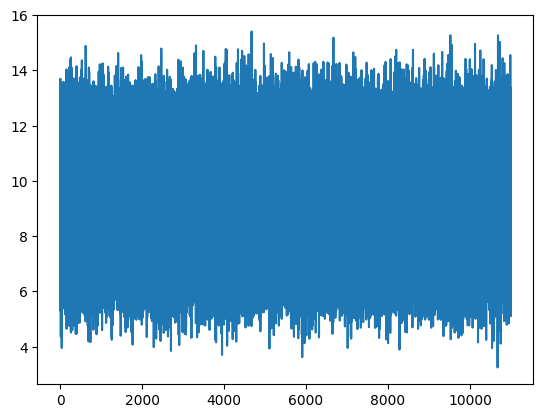

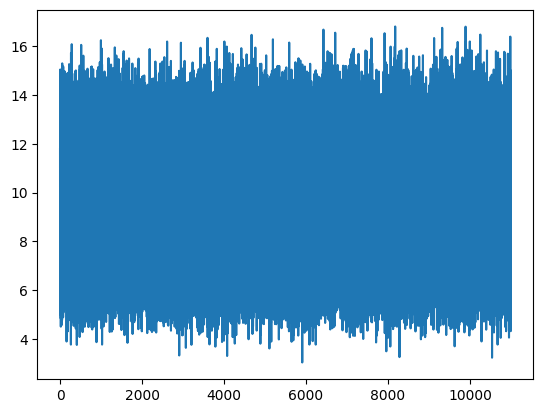

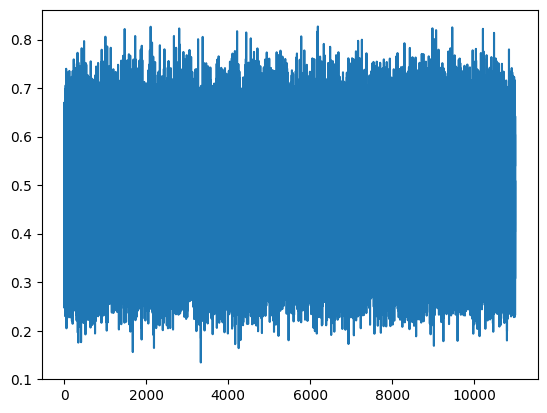

In [87]:
# BBN Parameters
psmodel = dbl_lorentz_fwhm

# Parameters for result 1
pspar = [.01, .16, 2*.29, 0.03, 0, 2*4.3] # Strong BBN
dt = 1/64 # Time bin size
ntimes = int(11000 /dt) # Length of light curve 
expquery = 'n' # exponentiation to make the light curve flux distribution lognormal

# Cannot set rms using my newly defined dbl_lorentz_fwhm function!
rms = 0. # Set to 0 to not re-normalize

f_min = 1./(dt*ntimes) # The minimum frequency is 1/(duration of light curve)
f_max = 1/(2.*dt) # The maximum 'Nyquist' frequency is 1/(2*sampling-interval) (i.e. 1/(2*binsize)
params = tuple(pspar)

# Broadening parameters
a0 = 0.015 # 0.0081 # 0.001 # 0.0001 # 0.00001 
nu0 = 0
hwhm = 0.2

# Energy band parameters
E_ref_meanctrate = 600 * dt
E_1_meanctrate = 30 * dt

lc_BBN_E_ref = simlc(dt, ntimes, expquery, rms, psmodel, pspar)
lc_BBN_E_sub = simlc(dt, ntimes, expquery, rms, psmodel, pspar)

lc_BBN_E_ref *= E_ref_meanctrate
lc_BBN_E_sub *= E_1_meanctrate

plt.plot(t, lc_BBN_E_sub)
plt.show()
plt.plot(t, lc_BBN_E_ref)
plt.show()

modulated_lc_ref = A_ref * lc_BBN_E_ref
modulated_lc_sub = A_sub * lc_BBN_E_sub

plt.plot(t, modulated_lc_ref)
plt.show()
plt.plot(t, modulated_lc_sub)
plt.show()


c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


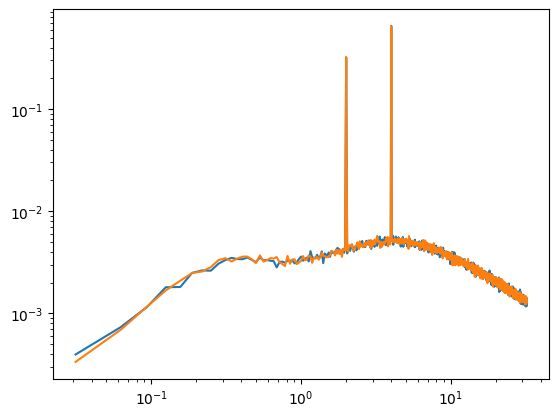

In [88]:
modulated_lc_ref = st.Lightcurve(t, modulated_lc_ref, dt = dt)
modulated_lc_sub = st.Lightcurve(t, modulated_lc_sub, dt = dt)

ps_ref = st.AveragedPowerspectrum(modulated_lc_ref, segment_size=32, dt=dt)
ps_E_1 = st.AveragedPowerspectrum(modulated_lc_sub, segment_size=32, dt=dt)

plt.plot(ps_ref.freq, ps_ref.power * ps_ref.freq)
plt.plot(ps_E_1.freq, ps_E_1.power * ps_E_1.freq)

plt.xscale('log')
plt.yscale('log')

In [89]:
Cbspec_segsize = 12 * 1/nu_f

segmented_counts_E_sub, segmented_times_E_sub, discard = split_multiple_lc(modulated_lc_sub.split_by_gti(), Cbspec_segsize, dt=dt)
segmented_counts_E_ref, segmented_times_E_ref, discard = split_multiple_lc(modulated_lc_ref.split_by_gti(), Cbspec_segsize, dt=dt)


avg_cbspec, freq, ind_cbspec = avg_cross_bispec(segmented_counts_E_ref, segmented_counts_E_sub, 0.1, 10, dt=dt, ret_ind_cbs=True)
avg_bspec, freq, ind_cbspec = avg_cross_bispec(segmented_counts_E_ref, segmented_counts_E_ref, 0.1, 10, dt=dt, ret_ind_cbs=True)

avg_cs = st.AveragedCrossspectrum.from_lightcurve(modulated_lc_sub, modulated_lc_ref, Cbspec_segsize)

deltaf_sub_recovered = np.angle(avg_cs.power[11])
deltah_sub_recovered = np.angle(avg_cs.power[23])

psi_recovered = -.5 * np.angle(avg_bspec[11, 11])
psi_BS = np.angle(avg_bspec[11, 11])
psi_CBS = np.angle(avg_cbspec[11, 11])
theta = np.angle(avg_cbspec[11, 11])

exp_theta = 2*psi + deltah_sub

print(psi_CBS, psi_BS + deltah_sub_recovered)
print(2 * psi + deltah_sub)
print(2*psi, psi_BS)

print('Expected and recovered deltaf_sub:', deltaf_sub, deltaf_sub_recovered)
print('Expected and recovered deltah_sub:', deltah_sub, deltah_sub_recovered)

print('Expected and recovered psi:', psi, psi_recovered)
print('Expected and recovered theta:', exp_theta, theta)

print('Input delta_h_sub:', deltah_sub)
print('Input psi:', psi)
print('Output theta:', theta)

2.510871532196462 2.4999864722828984
2.5132741228718345
1.8849555921538759 1.8602336349345112
Expected and recovered deltaf_sub: -0.0 -0.0018915819504218211
Expected and recovered deltah_sub: 0.6283185307179586 0.6397528373483873
Expected and recovered psi: 0.9424777960769379 -0.9301168174672556
Expected and recovered theta: 2.5132741228718345 2.510871532196462
Input delta_h_sub: 0.6283185307179586
Input psi: 0.9424777960769379
Output theta: 2.510871532196462


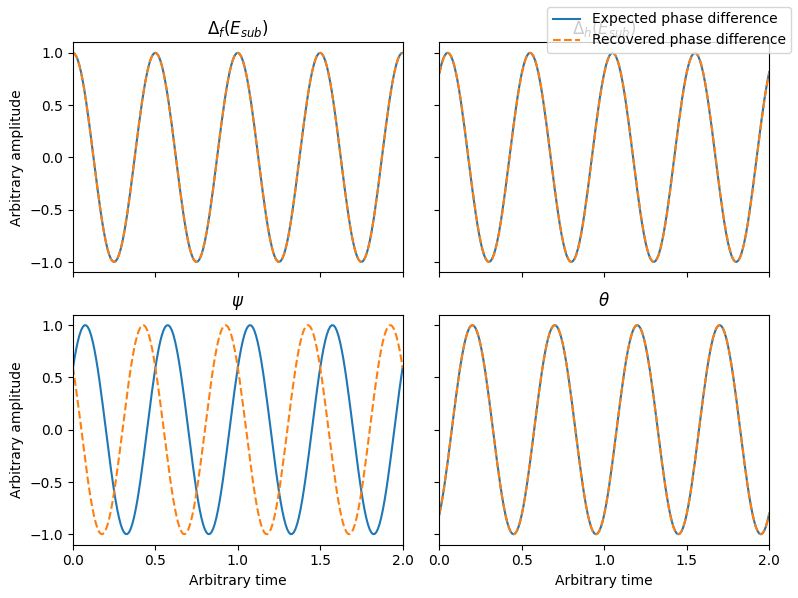

In [90]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey=True)

t_temp = np.linspace(0, 20, 2000)

w1 = np.cos(2*np.pi*nu_f*t_temp - deltaf_sub)
w2 = np.cos(2*np.pi*nu_f*t_temp - deltaf_sub_recovered)
ax1.plot(t_temp, w1, label='Expected phase difference')
ax1.plot(t_temp, w2, ls='--', lw=1.5, label='Recovered phase difference')

w1 = np.cos(2*np.pi*nu_f*t_temp - deltah_sub)
w2 = np.cos(2*np.pi*nu_f*t_temp - deltah_sub_recovered)
ax2.plot(t_temp, w1)
ax2.plot(t_temp, w2, ls='--', lw=1.5)

w1 = np.cos(2*np.pi*nu_f*t_temp - psi)
w2 = np.cos(2*np.pi*nu_f*t_temp - psi_recovered)
ax3.plot(t_temp, w1)
ax3.plot(t_temp, w2, ls='--', lw=1.5)

w1 = np.cos(2*np.pi*nu_f*t_temp - exp_theta)
w2 = np.cos(2*np.pi*nu_f*t_temp - theta)
ax4.plot(t_temp, w1)
ax4.plot(t_temp, w2, ls='--', lw=1.5)

ax3.set_xlim(0,2)

ax1.set_title(f'$\\Delta_f(E_{{sub}})$')
ax2.set_title(f'$\\Delta_h(E_{{sub}})$')
ax3.set_title(f'$\\psi$')
ax4.set_title(f'$\\theta$')

ax3.set_xlabel('Arbitrary time')
ax4.set_xlabel('Arbitrary time')
ax3.set_ylabel('Arbitrary amplitude')
ax1.set_ylabel('Arbitrary amplitude')

fig.legend()
fig.tight_layout()